Try to improve GRAPE model

Data
- bipartite representation with embeddings for gene nodes, constant features for cell nodes 

GNN
- explore other types of layers: GAT, GIN ... 
- explore heterogeneous layers: HGTConv, HEAT, HANConv
- add regularisation like DGN to layers

Imputation
- instead of MLP, use VAE to generate X'
- use losses from scGNN to measure X and X'
- look at loss function from ramon 

Prediction 
- clustering/classification model?
- DMoN clustering/pooling? --> look at its loss: spectral loss, orthogonality loss, cluster loss 
    - https://arxiv.org/pdf/2006.16904.pdf
- knn clustering --> metrics 

Experiments: 
- vary number of genes 
- evaluate how good imputed features are: dropout recovery 
- evaluate how good clusters are: https://github.com/theislab/scib/blob/b31d53b05d6b4b6bbc9aeba573d39cd16832ae97/scib/metrics/metrics.py
    - https://github.com/google-research/google-research/blob/master/graph_embedding/dmon/train.py#L200-L207

In [1]:
import pandas as pd

import torch
import torch.nn.functional as F 
import numpy as np

import matplotlib.pyplot as plt

import utils
import gnn 
from analysis import plot_loss, plot_acc, plot_loss_acc

from importlib import reload

# data 

In [2]:
from data import preprocess_paul15, preprocess_basic, get_paul15, get_pbmc3k, data_heterogeneous
import svm 

n_genes = 40
adata = preprocess_paul15(get_paul15(), n_top_genes=n_genes) 

n_train = 1800 
x_train, x_test, y_train, y_test = svm.split_data_cellclass(adata, n_train, target_col='paul15_clusters_ind')
clf = svm.svm_cellclass(x_train, y_train, x_test, y_test, kernel='linear')

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


/home/hbl/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/data.py:132: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['paul15_clusters_ind'] = adata.obs.paul15_clusters.replace(cats.to_list(), range(len(cats)))


SVM test accuracy: 42.90322580645161


In [3]:
import GRAPE.uci.uci_data as uci_data

split_sample = 0. 
node_mode = 0 
train_edge = 0.7 
split_by = 'y'
train_y = 0.7 
seed = 0

data = uci_data.load_data(adata, target_col='paul15_clusters_ind', node_mode=node_mode, train_edge=train_edge, split_sample=split_sample,
                        split_by=split_by, train_y=train_y, seed=seed)

# training and models

In [4]:
import GRAPE.training.gnn_mdi as gnn_mdi
import GRAPE.training.gnn_y as gnn_y

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### dataclass

In [5]:
from dataclasses import dataclass
import os

@dataclass 
class ArgsGnnModel: 
    aggr: str = 'mean'
    concat_states: bool = False
    dropout: float = 0. 
    edge_dim: int = 64 
    edge_mode: int = 1  # 0: use it as weight; 1: as input to mlp
    gnn_activation: str = 'relu'
    model_types: str = 'EGSAGE_EGSAGE_EGSAGE'
    node_dim: int = 64 
    norm_embs: str = None  # default to be all true
    post_hiddens: str = None  # default to be 1 hidden of node_dim
    embedding_input_dim: int = None  # for gene node embedding input; num of genes used 

@dataclass
class ArgsOptimizer: 
    epochs: int = 1000
    lr: float = 0.001
    opt: str = 'adam'
    opt_decay_rate: float = 0.9
    opt_decay_step: int = 1000
    opt_scheduler: str = None
    weight_decay: float = 0.
@dataclass 
class Args: 
    model: ArgsGnnModel = ArgsGnnModel()
    optimizer: ArgsOptimizer = ArgsOptimizer() 
    auto_known: bool = False
    ce_loss: bool = False 
    concat_states: bool = False
    dropout: float = 0.
    impute_activation: str = 'relu'
    impute_hiddens: str = '64'
    known: float = 0.7
    loss_mode: int = 0 
    mode: str = 'train'  # debug
    # norm_label
    save_model: bool = False
    save_prediction: bool = False
    split_sample: float = 0.
    split_test: bool = False 
    split_train: bool = False 
    transfer_dir: str = None
    transfer_extra: str = ''
    valid: float = 0.
    log_path: str = ''

    predict_hiddens: str = ''
    output_activation: str = None 

### hyper params

In [6]:
args_opt = optimizer = ArgsOptimizer(epochs=1001)

### mdi

In [8]:
utils.seed(0)
args_mdi = Args(optimizer = args_opt, log_path='paul15_mdi')

log_path = './test/{}/'.format(args_mdi.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, obj = gnn_mdi.train_gnn_mdi(data, args_mdi, log_path, device)
# [Epoch 0] train (loss=0.01963968202471733) test (rms=0.14331020894571264, l1=0.09327643364667892)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  26
train edge num is 152958, test edge num is input 152958, output 65442
[Epoch 0] train (loss=0.06292133033275604) test (rms=0.21572492398839696, l1=0.1166234090924263)
[Epoch 100] train (loss=0.02630718983709812) test (rms=0.16308924962866334, l1=0.08974449336528778)
[Epoch 200] train (loss=0.022553039714694023) test (rms=0.1593403678085471, l1=0.08328317850828171)


(<Figure size 640x320 with 1 Axes>, <AxesSubplot:>)

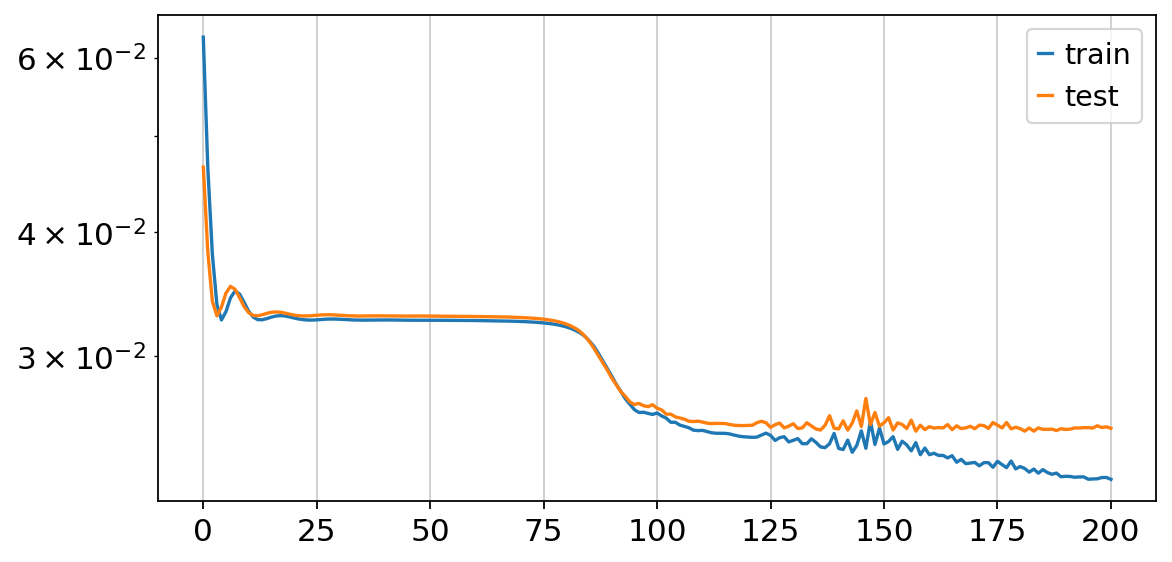

In [9]:
plot_loss(obj)

### downstream

#### target class number

In [11]:
utils.seed(0)
args_y = Args(optimizer = args_opt, log_path='paul15_y')

log_path = './test/{}/'.format(args_y.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, predict_model, obj = gnn_y.train_gnn_y(data, args_y, log_path, device)
# [Epoch 0] train (loss=88.68339538574219) test (rms=9.668847813570766, l1=8.222831726074219)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  28 total model parameters: 92138
all y num is 2730, train num is 1885, test num is 845
[Epoch 0] train (loss=89.57461547851562) test (rms=9.48093026212375, l1=8.0011568069458)
[Epoch 100] train (loss=32.76383972167969) test (rms=5.6745965486535015, l1=4.866486549377441)
[Epoch 200] train (loss=16.373998641967773) test (rms=3.7152132799169144, l1=3.12895131111145)


(<Figure size 640x320 with 1 Axes>, <AxesSubplot:>)

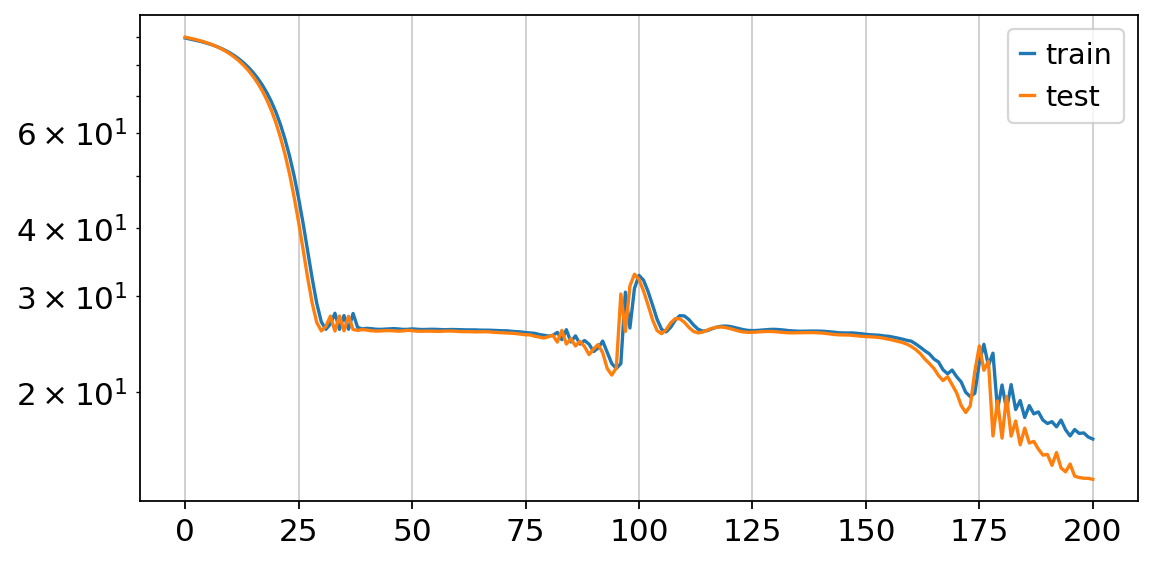

In [12]:
plot_loss(obj)

#### one hot targets

In [13]:
utils.seed(0)
data_onehot = uci_data.load_data(adata, target_col='paul15_clusters_ind', node_mode=node_mode, train_edge=train_edge, 
    split_sample=split_sample, split_by=split_by, train_y=train_y, seed=seed, one_hot=True)
args_y = Args(optimizer = args_opt, log_path='paul15_y_softmax', output_activation='softmax')

log_path = './test/{}/'.format(args_y.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, predict_model, obj = gnn_y.train_gnn_y(data_onehot, args_y, log_path, device)
# [Epoch 0] train (loss=0.049670442938804626) test (rms=0.2227822332169209, l1=0.09944138675928116)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  28 total model parameters: 92876
all y num is 2730, train num is 1885, test num is 845
[Epoch 0] train (loss=0.04975923150777817) test (rms=0.22304028302554593, l1=0.09958266466856003)
[Epoch 100] train (loss=0.048333898186683655) test (rms=0.219979433146839, l1=0.09654673933982849)
[Epoch 200] train (loss=0.048318345099687576) test (rms=0.21990988818985296, l1=0.09682223945856094)


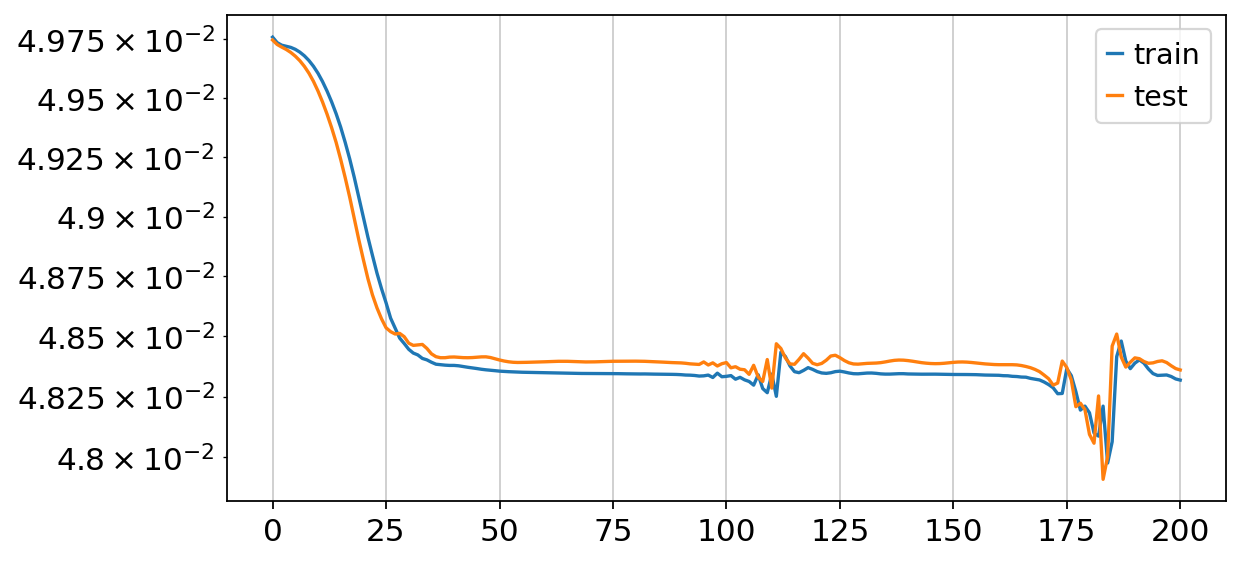

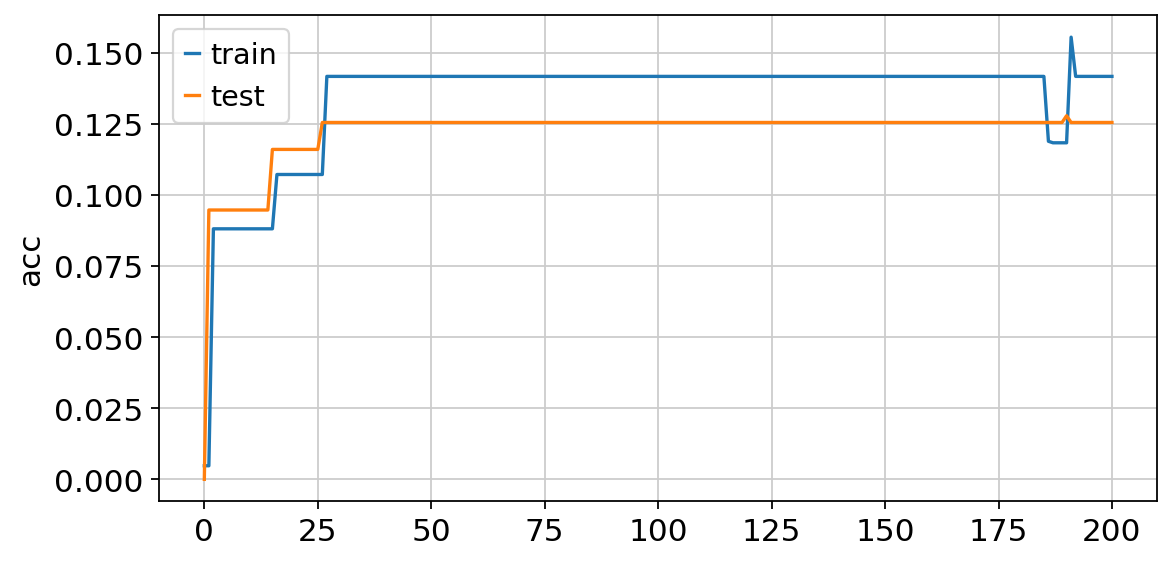

In [14]:
fig, ax = plot_loss(obj)
fig.show()
fig, ax = plot_acc(obj)
fig.show()

#### try embedding and splitting up node types - heterogeneous graph

In [7]:
utils.seed(0)
data_1 = uci_data.load_data(adata, target_col='paul15_clusters_ind', node_mode=2, 
        train_edge=train_edge, split_sample=split_sample, split_by=split_by, train_y=train_y, seed=seed,
        one_hot=True)
nrow, ncol = adata.X.shape 

emb_dim = 16 
data_het = data_heterogeneous(data_1, emb_dim)

print(data_het.node_types)
print(data_het.edge_types)
print([(t, data_het.get_node_store(t)['x'].shape) for t in data_het.node_types])
print([(t, data_het.get_edge_store(*t)['edge_attr'].shape) for t in data_het.edge_types])
print([(t, data_het.get_edge_store(*t)['edge_index'].shape) for t in data_het.edge_types])

['cell', 'gene']
[('cell', 'has-expression', 'gene'), ('gene', 'is-expressed', 'cell')]
[('cell', torch.Size([2730, 16])), ('gene', torch.Size([40, 1]))]
[(('cell', 'has-expression', 'gene'), torch.Size([109200, 1])), (('gene', 'is-expressed', 'cell'), torch.Size([109200, 1]))]
[(('cell', 'has-expression', 'gene'), torch.Size([2, 109200])), (('gene', 'is-expressed', 'cell'), torch.Size([2, 109200]))]


In [8]:
utils.seed(0)
args_y = Args(model = ArgsGnnModel(embedding_input_dim=n_genes), optimizer = args_opt, log_path='paul15_y_softmax_embedgenes', output_activation='softmax')

log_path = './test/{}/'.format(args_y.log_path)
os.makedirs(log_path, exist_ok=True)
model, impute_model, predict_model, obj = gnn_y.train_gnn_y(data_het, args_y, log_path, device)
# [Epoch 0] train (loss=0.04983777180314064) test (rms=0.049798544496297836, l1=0.09964697062969208)
# [Epoch 1000] train (loss=0.040213510394096375) test (rms=0.040499404072761536, l1=0.07955311983823776)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]
total trainable_parameters:  29 total model parameters: 90444
all y num is 2730, train num is 1885, test num is 845
[Epoch 0] train (loss=0.04983777180314064) test (rms=0.049798544496297836, l1=0.09964697062969208)
[Epoch 100] train (loss=0.04834458604454994) test (rms=0.04839102178812027, l1=0.09674721956253052)
[Epoch 200] train (loss=0.04834338650107384) test (rms=0.04839121177792549, l1=0.09673937410116196)
[Epoch 300] train (loss=0.04716438055038452) test (rms=0.04657725617289543, l1=0.09323541074991226)
[Epoch 400] train (loss=0.04360390827059746) test (rms=0.04323985427618027, l1=0.08683661371469498)
[Epoch 500] train (loss=0.04339567944407463) test (rms=0.04243406653404236, l1=0.08512407541275024)
[Epoch 600] train (loss=0.04189998283982277) test (rms=0.041650570929050446, l1=0.08197565376758575)
[Epoch 700] train (loss=0.041531387716531754) test (rms=0.04158290848135948, l1=0.08172384649515152)
[Epoch 800] train (loss=0.04

final test acc: tensor(33.2544)


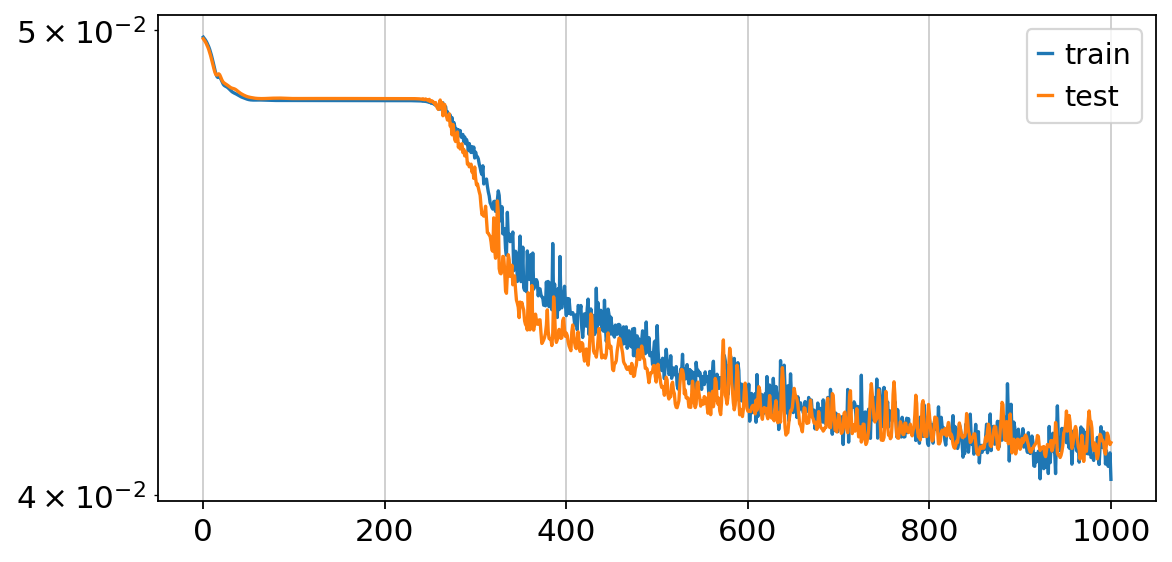

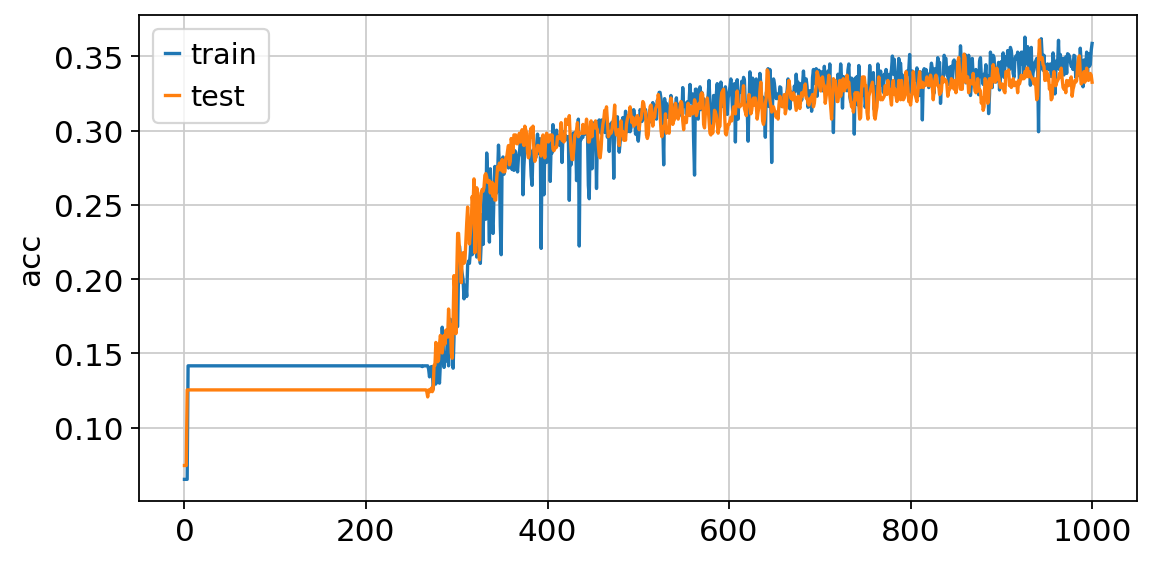

In [13]:
fig, ax = plot_loss(obj)
fig.show()
fig, ax = plot_acc(obj)
fig.show()
print('final test acc:', gnn.calc_accuracy(
    torch.tensor(obj['outputs']['pred_test']), 
    torch.tensor(obj['outputs']['label_test'])))

# analysis

In [12]:
torch.cuda.empty_cache()

In [26]:
data = data_het 

n_row, n_col = data.df_X.shape
x = {k: v.clone().detach().to(device) for k,v in data.collect('x').items()}
train_edge_index = data.train_edge_index.clone().detach().to(device)
train_edge_attr = data.train_edge_attr.clone().detach().to(device)
edge_index = torch.cat([data.get_edge_store(*t)['edge_index'] for t in data.edge_types], axis=1).clone().detach().to(device)
test_y_mask = data.test_y_mask.clone().detach().to(device)

# data_het.x_dict
# data_het.edge_index_dict

In [14]:
model

GNNStack(
  (embedding): GeneCellEmbedding(
    (gene_embedding): Embedding(40, 16)
  )
  (convs): ModuleList(
    (0): EGraphSage(16, 64)
    (1): EGraphSage(64, 64)
    (2): EGraphSage(64, 64)
  )
  (node_post_mlp): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (edge_update_mlps): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=129, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): ReLU()
    )
  )
)

In [15]:
with torch.no_grad():
    x_embd = model(x, train_edge_attr, train_edge_index)
    X = impute_model([x_embd[edge_index[0, :int(n_row * n_col)]], x_embd[edge_index[1, :int(n_row * n_col)]]])
    X = torch.reshape(X, [n_row, n_col])
    pred = predict_model(X).squeeze()


In [176]:
import analysis

In [184]:
reload(analysis)

<module 'analysis' from '/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/analysis.py'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


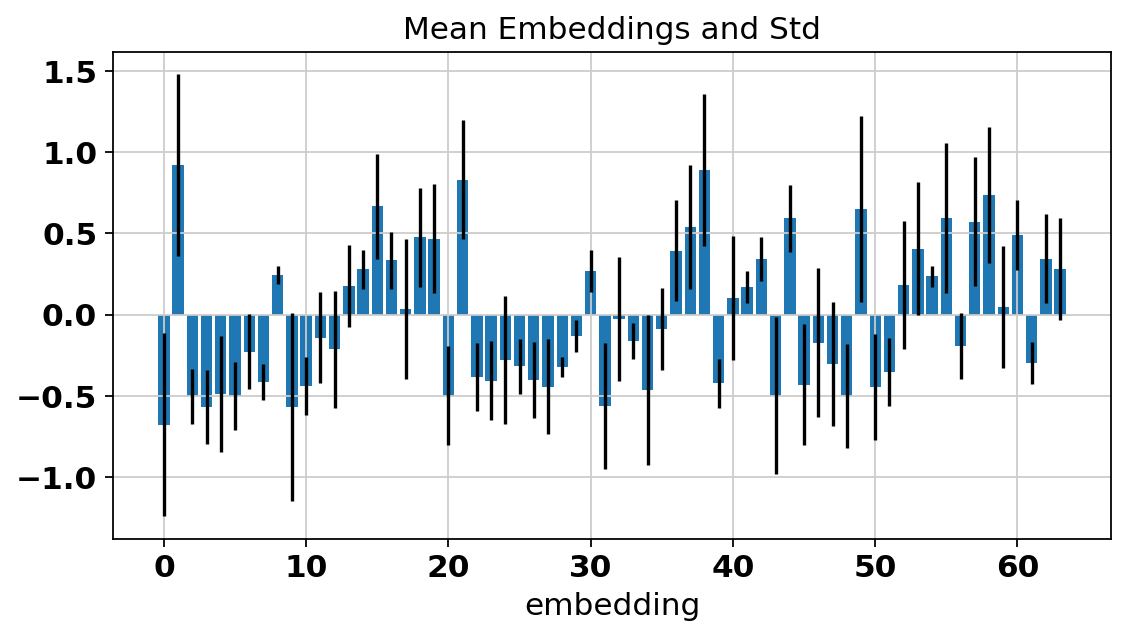

In [181]:
fig, ax = analysis.plot_embeddings(x_embd[:nrow].cpu())

In [185]:
print(analysis.similarity_metrics(torch.tensor(data.df_X.values).to(device), X))

{'cosine': -0.3335208594799042, 'l1': 2.6032967567443848, 'mse': 9.65419864654541}


In [54]:
mask = data.test_y_mask
test_labels = data.y[mask].argmax(axis=1)
test_predictions = pred[mask].cpu().argmax(axis=1)
correct_pred = (test_predictions == test_labels).float()
correct_pred.mean()

tensor(0.3314)

In [105]:
unique_labels = range(data.y.shape[1])
label_counts = {l: 0 for l in unique_labels}
label_accuracies = {l: 0. for l in unique_labels}
for l,p in zip(test_labels, correct_pred): 
    label_counts[l.item()] += 1
    label_accuracies[l.item()] += p.item()
for l in unique_labels: 
    if label_counts[l] > 0:
        label_accuracies[l] /= label_counts[l]
    else:
        label_accuracies[l] = np.nan
assert sum(label_counts.values()) == test_labels.shape[0]
print(label_counts)
print(label_accuracies)


{0: 8, 1: 106, 2: 80, 3: 38, 4: 50, 5: 56, 6: 46, 7: 18, 8: 21, 9: 52, 10: 7, 11: 29, 12: 98, 13: 106, 14: 63, 15: 46, 16: 10, 17: 0, 18: 11}
{0: 0.0, 1: 0.9622641509433962, 2: 0.0125, 3: 0.0, 4: 0.0, 5: 0.32142857142857145, 6: 0.7391304347826086, 7: 0.0, 8: 0.0, 9: 0.17307692307692307, 10: 1.0, 11: 0.0, 12: 0.061224489795918366, 13: 0.8773584905660378, 14: 0.06349206349206349, 15: 0.13043478260869565, 16: 0.0, 17: nan, 18: 0.0}


<BarContainer object of 19 artists>

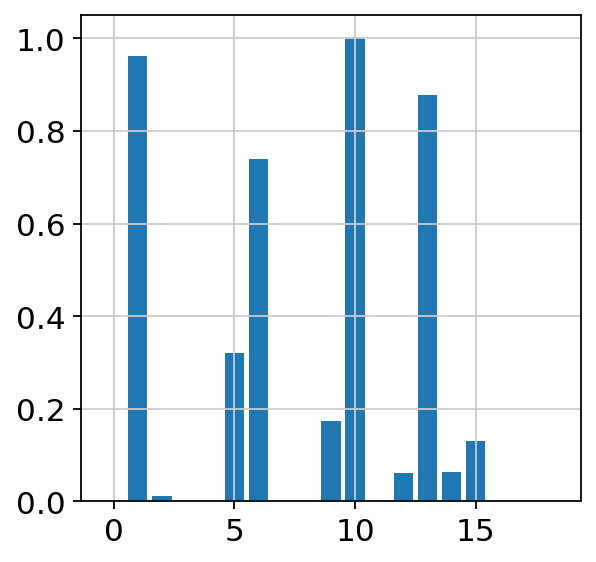

In [106]:
plt.bar(unique_labels, [label_accuracies[l] for l in unique_labels])

In [79]:
import pandas as pd

(<Figure size 480x720 with 2 Axes>,
 {'counts': <AxesSubplot:label='counts', xlabel='label', ylabel='count'>,
  'accs': <AxesSubplot:label='accs', xlabel='label', ylabel='prediction'>})

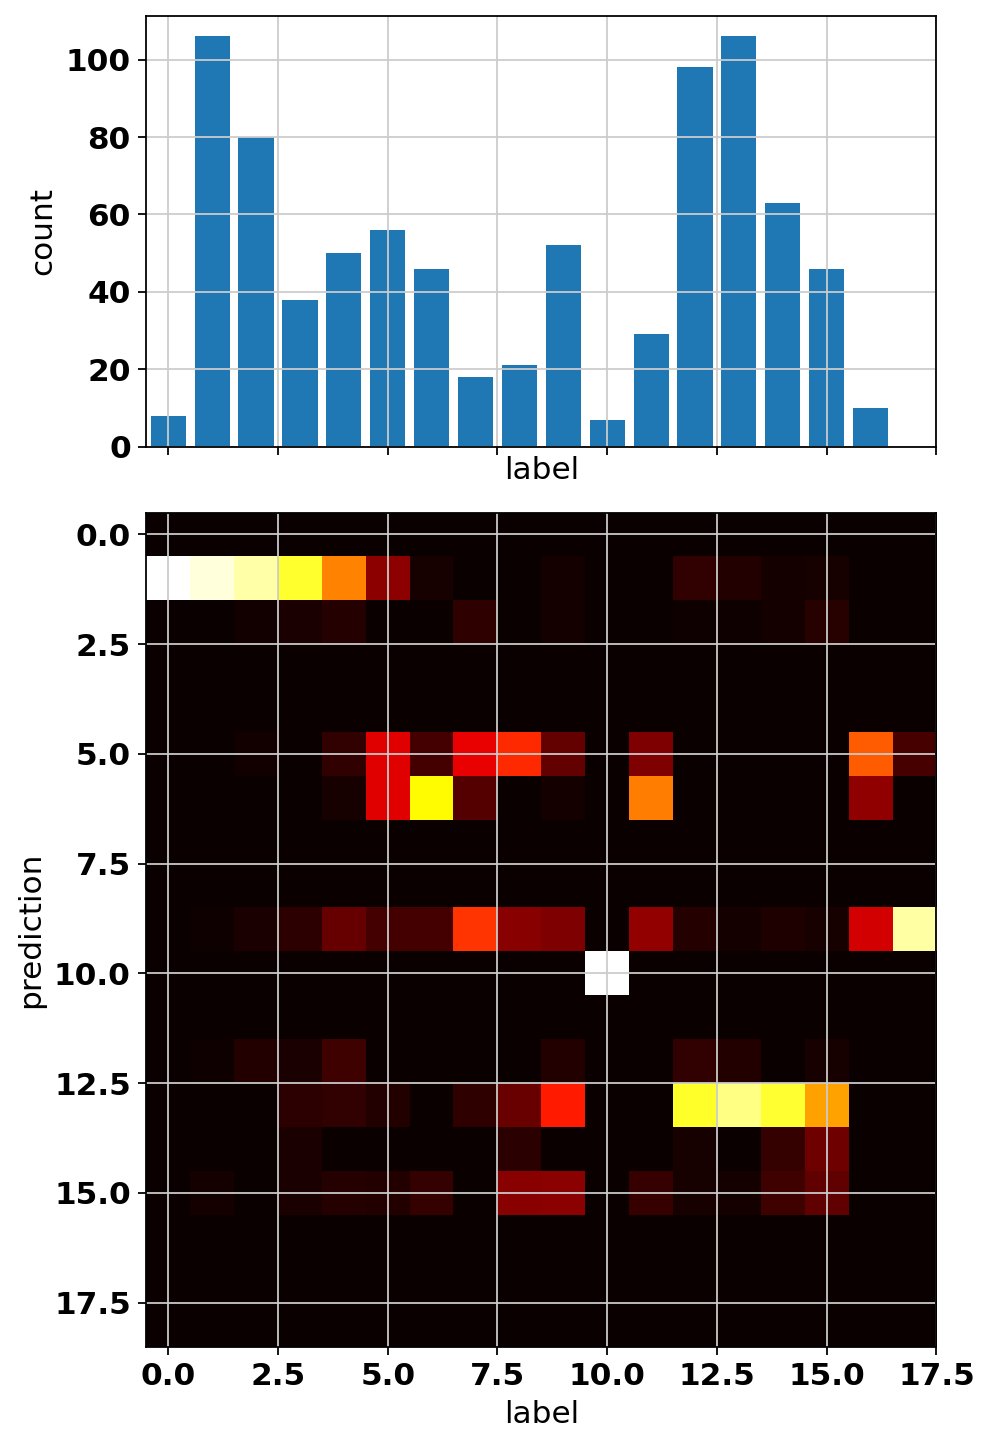

In [188]:
analysis.class_accuracies(test_labels, test_predictions, unique_labels)

i guess this shows mode collapse? predictions are being heavily swung by classes with the highest counts?

# augmentation

In [8]:
import GRAPE.models.gnn_model as gnn_model
from GRAPE.models.prediction_model import MLPNet

import grape

In [24]:
data_1 = uci_data.load_data(adata, target_col='paul15_clusters_ind', node_mode=2, 
        train_edge=train_edge, split_sample=split_sample, split_by=split_by, train_y=train_y, seed=seed,
        one_hot=True)

emb_dim = 16 
data = data_heterogeneous(data_1, emb_dim)

In [70]:
args_opt = optimizer = ArgsOptimizer(epochs=1001)
args = Args(model = ArgsGnnModel(embedding_input_dim=n_genes), optimizer = args_opt, log_path='paul15_y_softmax_embedgenes', output_activation='softmax')

model = gnn_model.get_gnn(data, args.model).to(device)

['EGSAGE', 'EGSAGE', 'EGSAGE'] [True, True, True] [64]


In [71]:
impute_hiddens = list(map(int, args.impute_hiddens.split('_')))
input_dim = args.model.node_dim * 2

output_dim = 1  # imputation output is 1
impute_model = MLPNet(input_dim, output_dim,
                        hidden_layer_sizes=impute_hiddens,
                        hidden_activation=args.impute_activation,
                        dropout=args.dropout).to(device)
impute_model

MLPNet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Identity()
    )
  )
)

In [72]:
predict_hiddens = [64, 64]
output_dim = 1 if len(data.y.shape) == 1 else data.y.shape[1]
predict_model = MLPNet(n_genes, output_dim,
                       output_activation=args.output_activation, 
                       hidden_layer_sizes=predict_hiddens,
                       dropout=args.dropout).to(device)
predict_model

MLPNet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=40, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=19, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

In [ ]:
predict_model = gnn.GNN('GCN', input_dim, output_dim, num_layers=1, hidden_dim=args.hidden_dim)

In [73]:
torch.cuda.empty_cache()

In [56]:
utils.seed(0)
x, edge_index, y, train_edge_index, train_edge_attr, train_y_mask, test_y_mask, n_row, n_col = grape.process_data(data, device=device)

all y num is 2730, train num is 1885, test num is 845


In [74]:
utils.seed(0)
obj = grape.train_y(args, model, impute_model, predict_model, 
    x, edge_index, y, 
    train_edge_index, train_edge_attr, train_y_mask, test_y_mask,
    n_row, n_col,  
    record_interval=10, log_interval=100, device=device
)

# [64] [Epoch 1000] train (loss=0.03972196951508522) test (loss=0.04009067267179489)

total trainable_parameters:  33 total model parameters: 97684
[Epoch 0] train (loss=0.04986283928155899) test (loss=0.049840837717056274)
[Epoch 100] train (loss=0.04834386333823204) test (loss=0.04839186742901802)
[Epoch 200] train (loss=0.04834338277578354) test (loss=0.0483914390206337)


final test acc: tensor(36.4497)


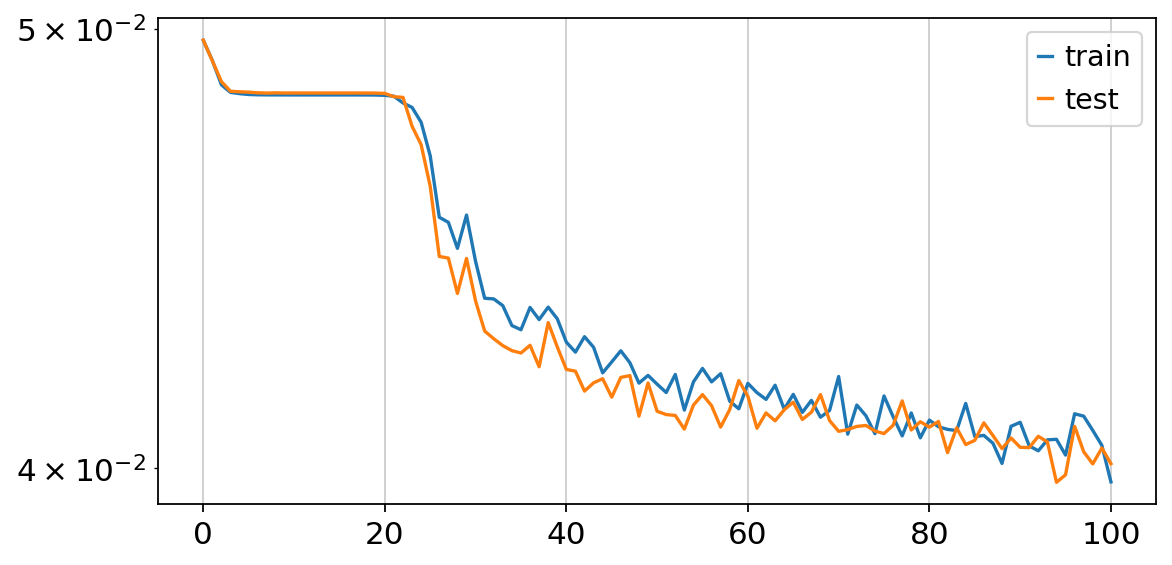

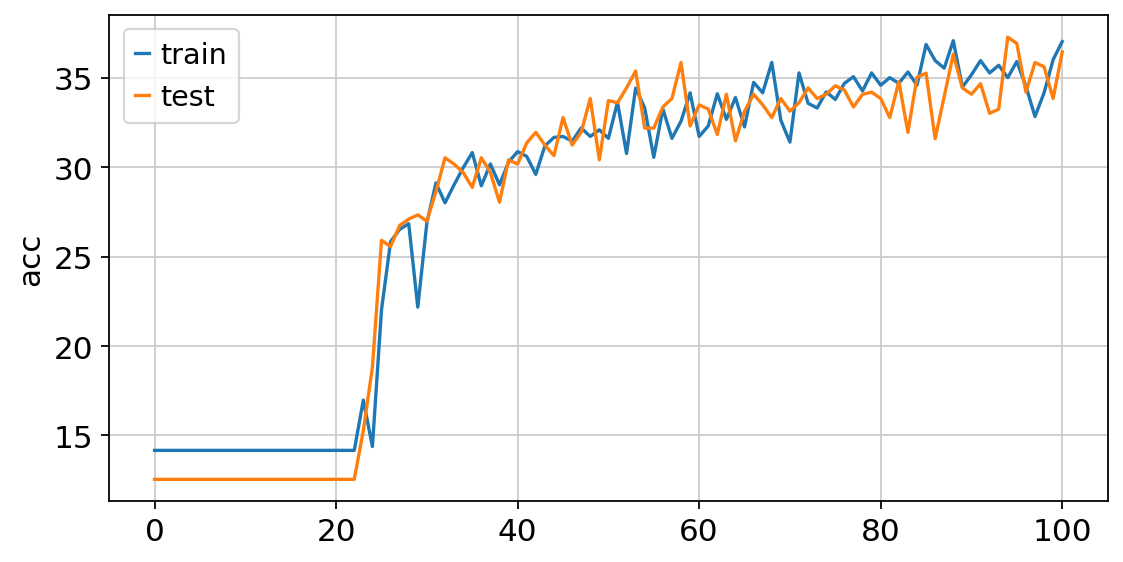

In [58]:
fig, ax = plot_loss(obj)
fig.show()
fig, ax = plot_acc(obj)
fig.show()
print('final test acc:', gnn.calc_accuracy(torch.tensor(obj['outputs']['pred_test']), torch.tensor(obj['outputs']['label_test'])))

(<Figure size 640x320 with 2 Axes>, <AxesSubplot:>)

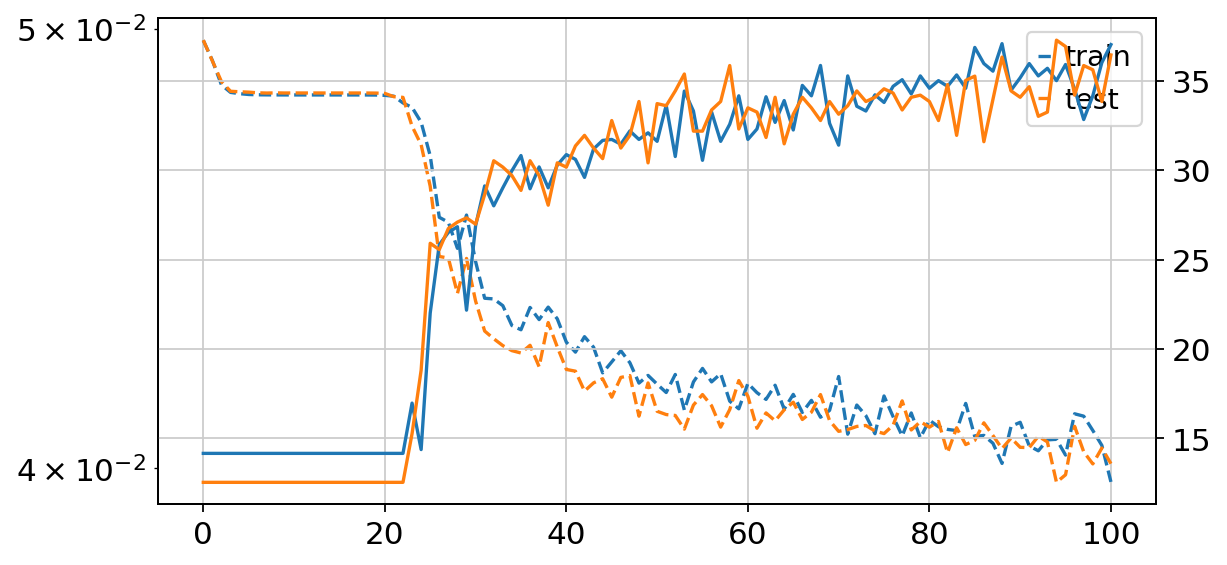

In [69]:
plot_loss_acc(obj)

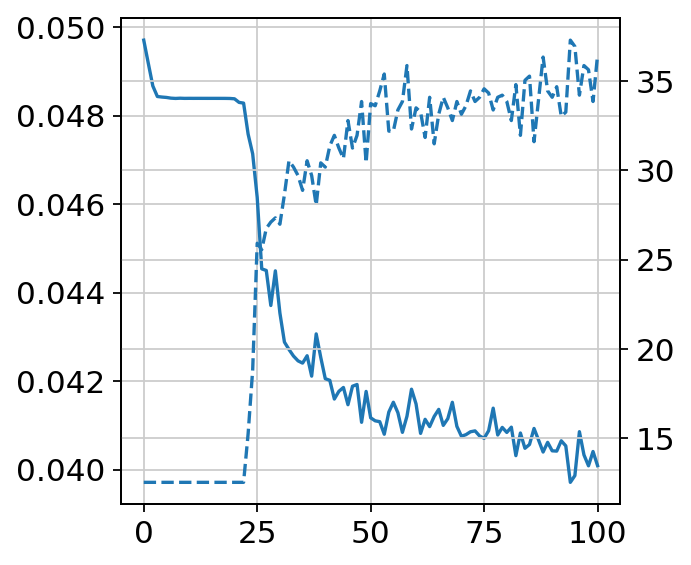

In [65]:
fig, ax = plt.subplots()
ax.plot(obj['curves']['test_loss'])
ax2 = ax.twinx()
ax2.plot(obj['curves']['test_acc'],'--' )